In [64]:
from sculptor import speconed as sod
from astropy.io import fits
import astropy.units as units
import matplotlib.pyplot as plt

In [65]:
#pip install simplejson

In [66]:
file = "J030341.04-002321.8_0.fits"
hdu = fits.open(file)

In [67]:
wavelength = 10**hdu[1].data['loglam']
flux = hdu[1].data['flux']
inv_var = hdu[1].data['ivar']

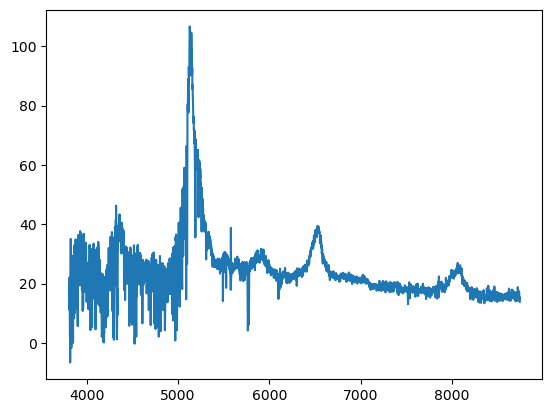

In [68]:
plt.plot(wavelength,flux)

In [69]:
hdr =  hdu[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TAI     =        4477028053.74 / 1st row - Number of seconds since Nov 17 1858  
RA      =            45.787818 / 1st row - Right ascension of telescope boresigh
DEC     =           -0.017770  / 1st row - Declination of telescope boresight (d
EQUINOX =              2000.00 /                                                
RADECSYS= 'FK5     '           /                                                
TAIHMS  = '10:36:49.28'        / 1st row - TAI time (HH:MM:SS.SS) (TAI-UT = appr
TIMESYS = 'tai     '           / TAI, not UTC                                   
MJD     =                51817 / MJD of observation                             
MJDLIST = '51817   '        

In [70]:
hdr['BUNIT'], hdr['WAT1_001']
flux_unit = 1e-17 * units.erg/units.s/units.cm**2/units.AA
wave_unit = 1.*units.AA

In [71]:
spec = sod.SpecOneD(dispersion=wavelength, fluxden = flux, fluxden_ivar=inv_var, fluxden_unit=flux_unit,dispersion_unit=wave_unit, header=hdr)

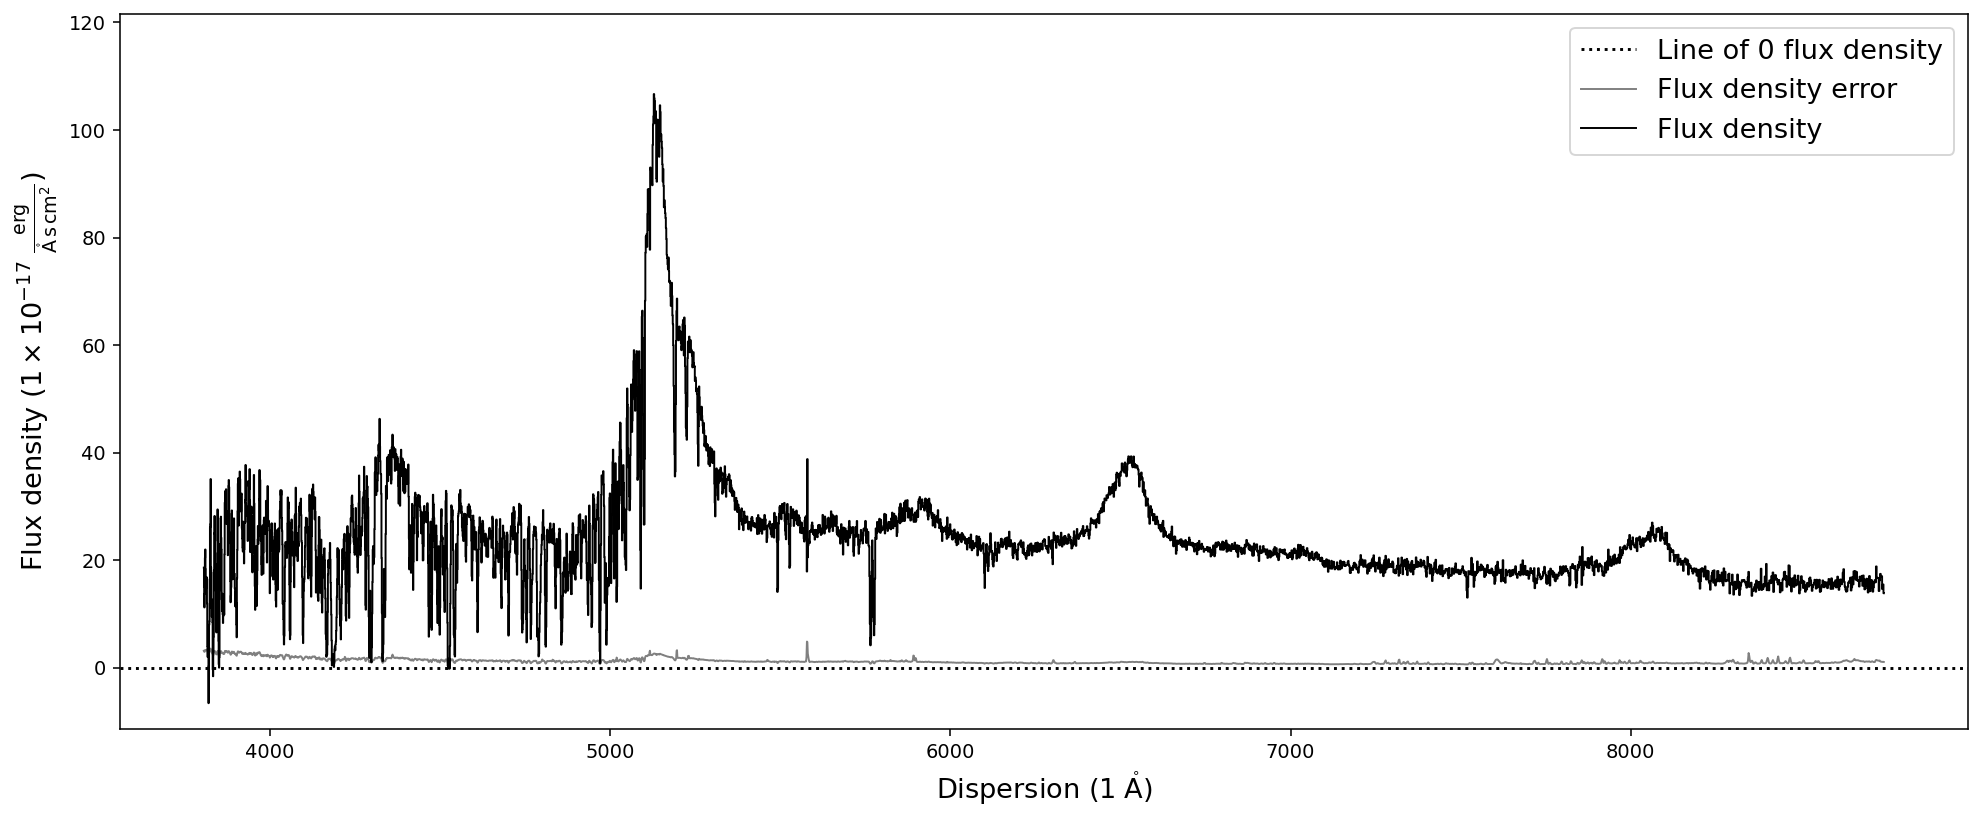

In [72]:
spec.plot()

In [73]:
#spec.convert_spectral_units(1*units.AA,1*units.mJy)

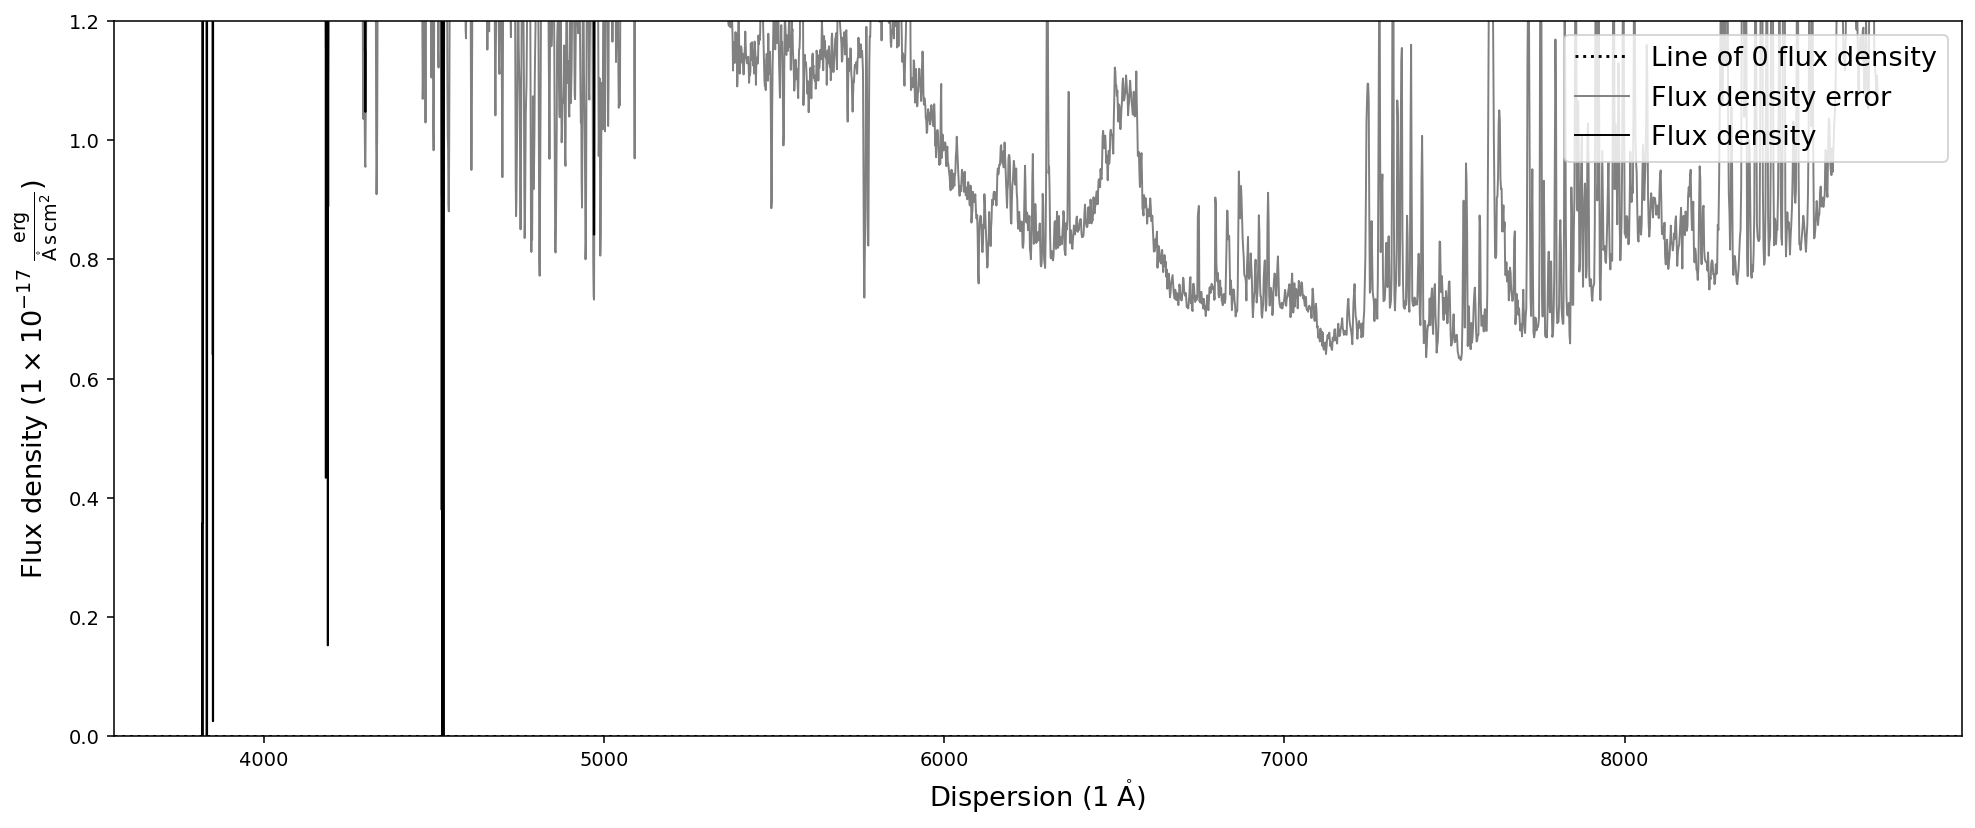

In [74]:
spec.plot(ymin=0.,ymax=1.2)

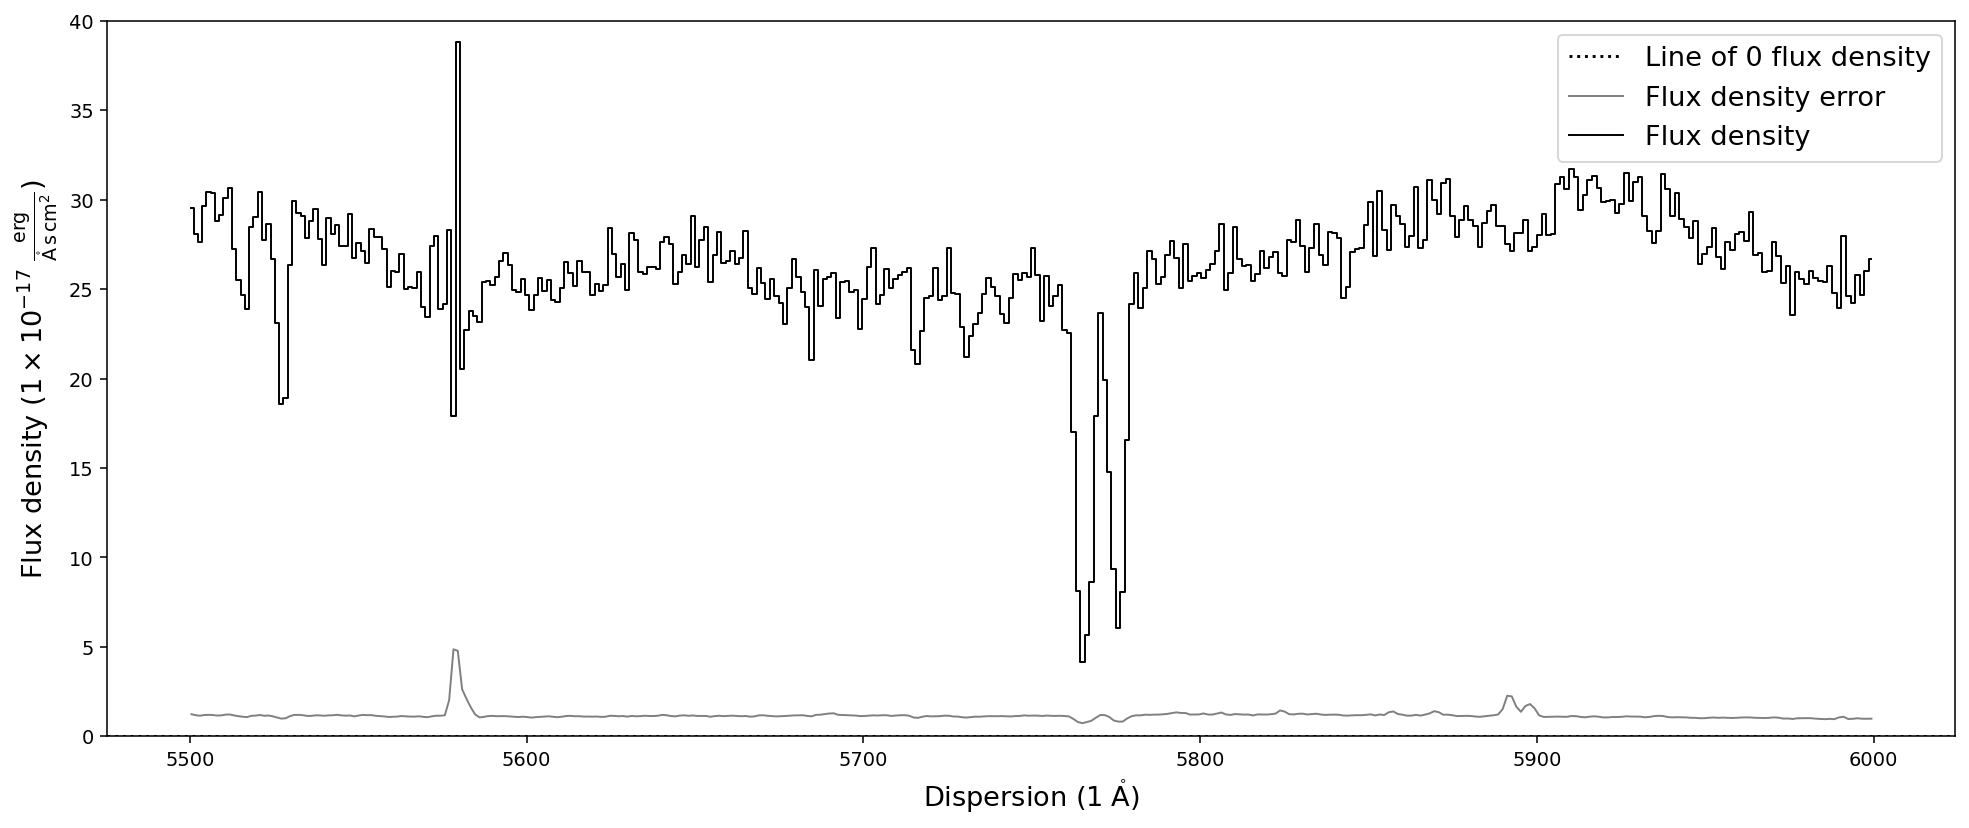

In [75]:
spec.trim_dispersion([5500,6000]).plot(ymin=0,ymax=40) #TWo absorption features

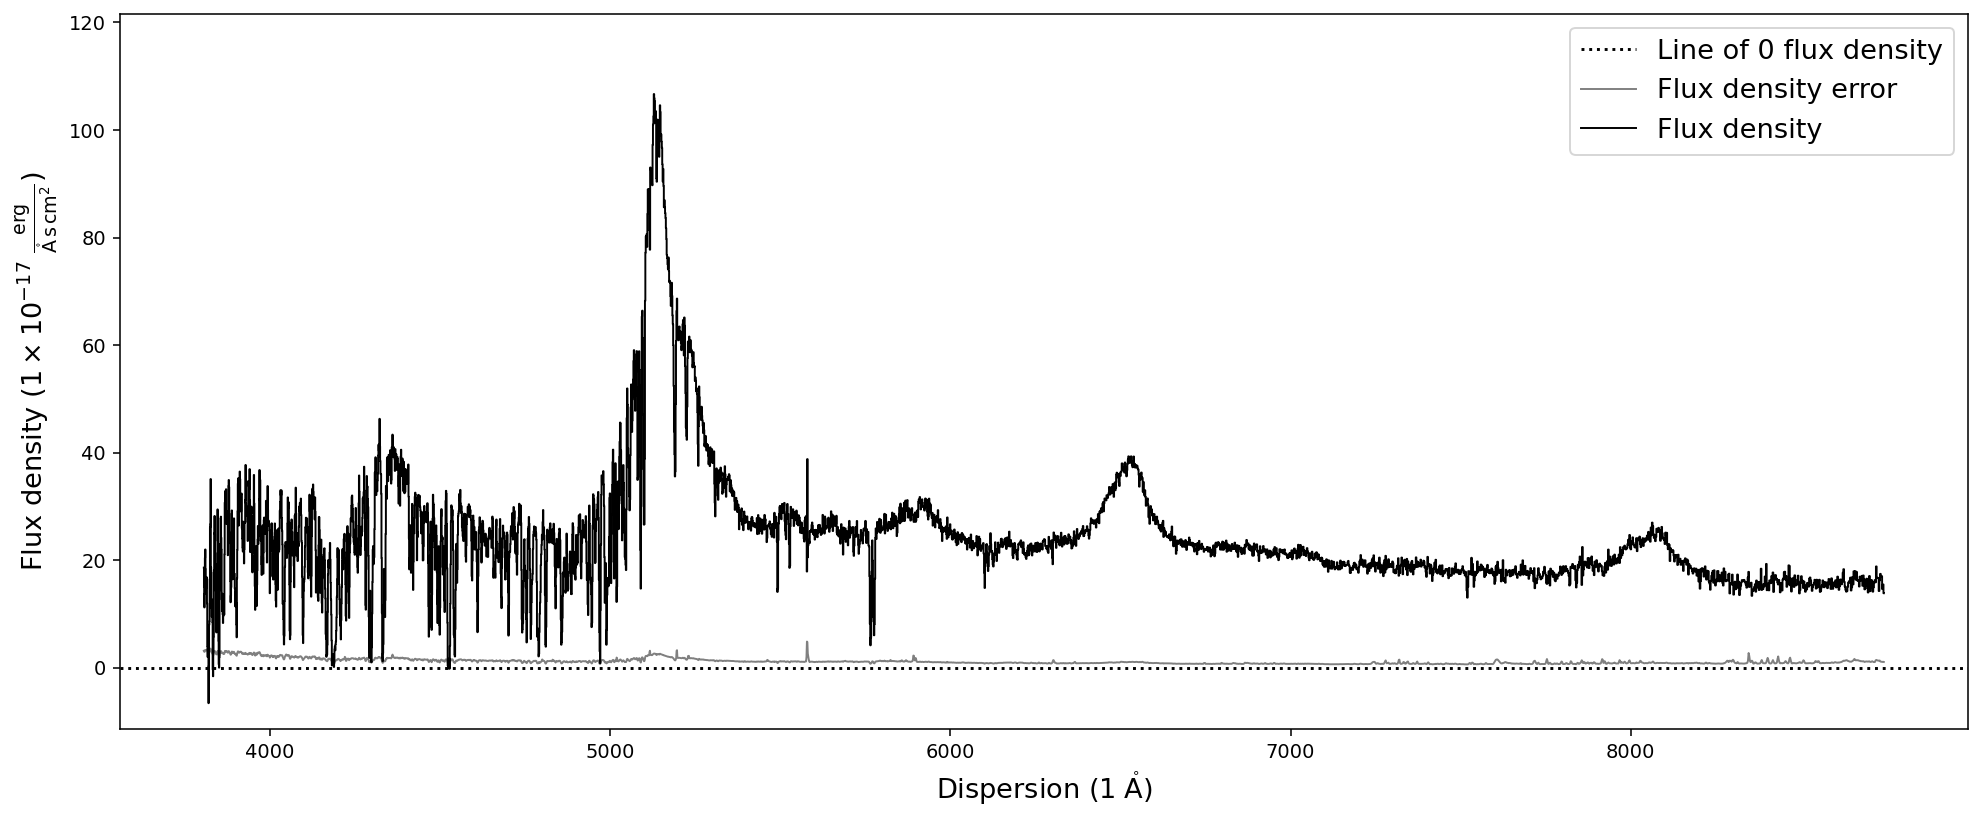

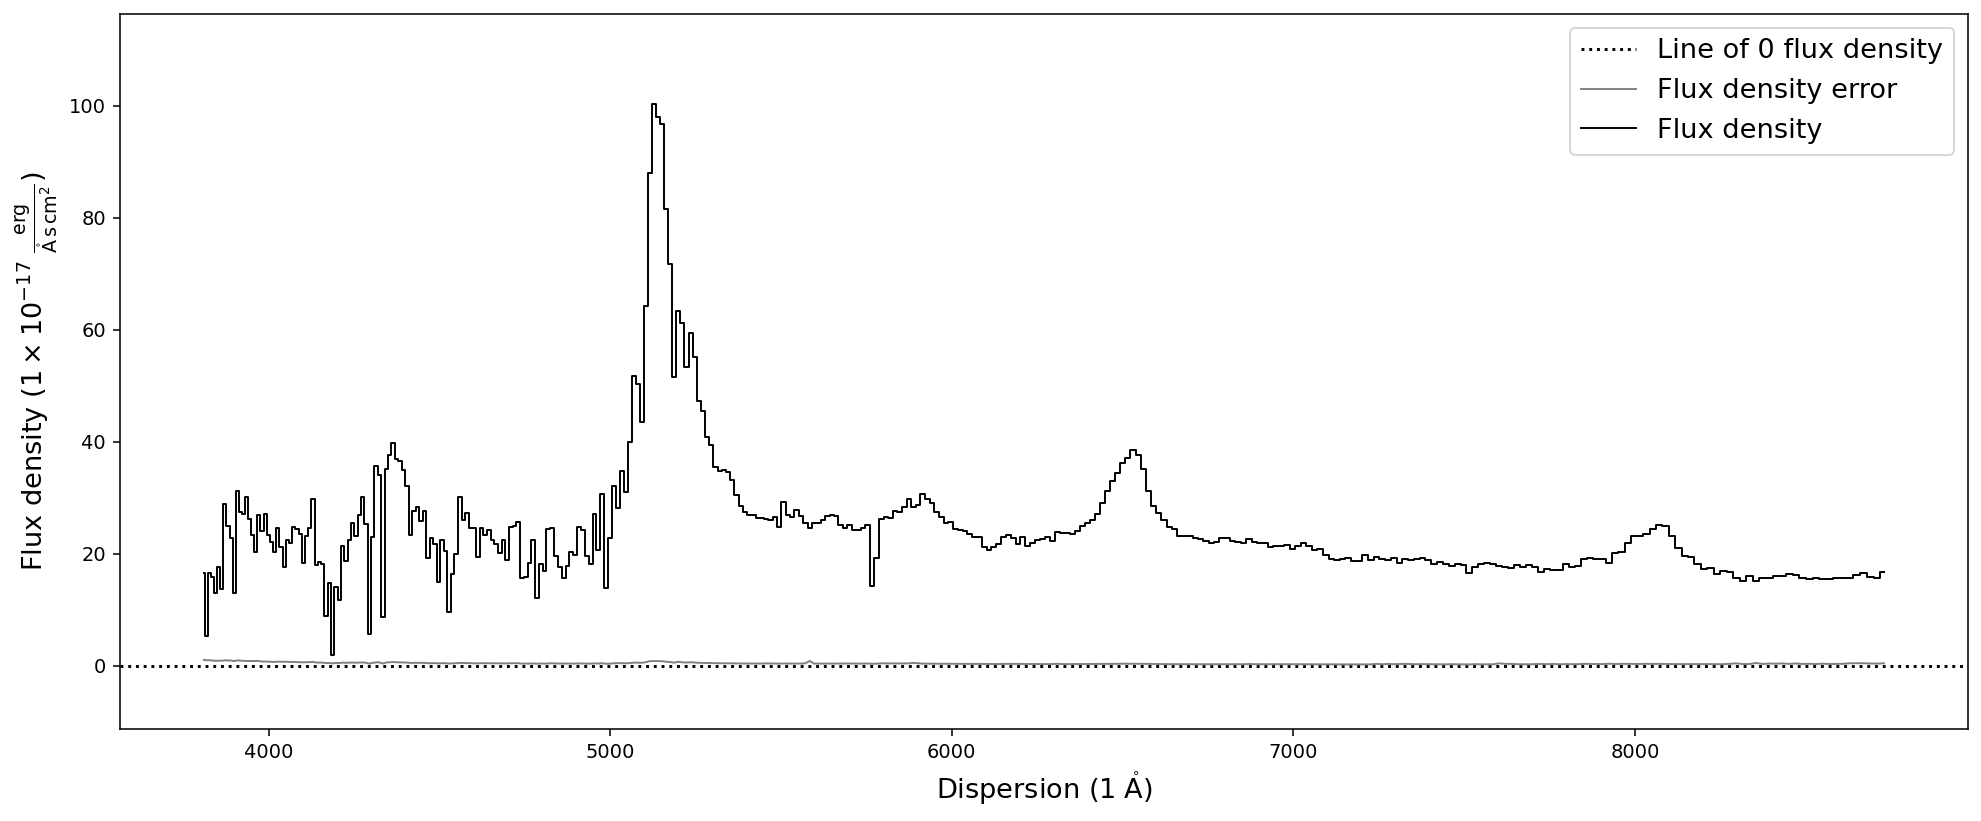

In [76]:
#Binning the spectrum by 10 pixels
spec.plot()
spec.bin_by_npixels(10).plot()

In [77]:
#Introducing SpecFit and SpecModel classes to model and fit the spectrum
#spec.plot()

from sculptor import specfit as scfit
from sculptor import specmodel as scmod

In [78]:
redshift = 3.227
fit = scfit.SpecFit(spec, redshift)

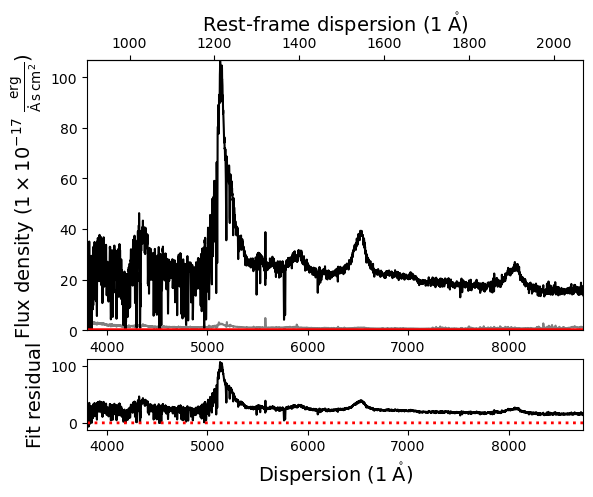

In [79]:
fit.plot()

In [80]:
#Fitting the Continuum 

#Add continuum model
fit.add_specmodel()

#access the initialized SpecModel object by using the first item in the SpecFit.specmodels list
contmodel = fit.specmodels[0]

#name the model
contmodel.name = 'continuum'

#Define the model name used to fit the continuum
model_name = 'Power Law (2500A)'

# Define the model prefix. It is important to keep track of the prefix to later access this model in the analysis
model_prefix = 'PL_'


# Add the continuum model function and prefix to the SpecModel
contmodel.add_model(model_name, model_prefix)

In [81]:
#Define wavelength windows which are free from (strong) emission lines to fit the continuum
contmodel.add_wavelength_range_to_fit_mask(8300, 8620)
contmodel.add_wavelength_range_to_fit_mask(7105, 7205)
contmodel.add_wavelength_range_to_fit_mask(5400, 5450)
contmodel.add_wavelength_range_to_fit_mask(5685, 5750)
contmodel.add_wavelength_range_to_fit_mask(6145, 6212)

[INFO] Manual mask range 8300 8620
[INFO] Manual mask range 7105 7205
[INFO] Manual mask range 5400 5450
[INFO] Manual mask range 5685 5750
[INFO] Manual mask range 6145 6212


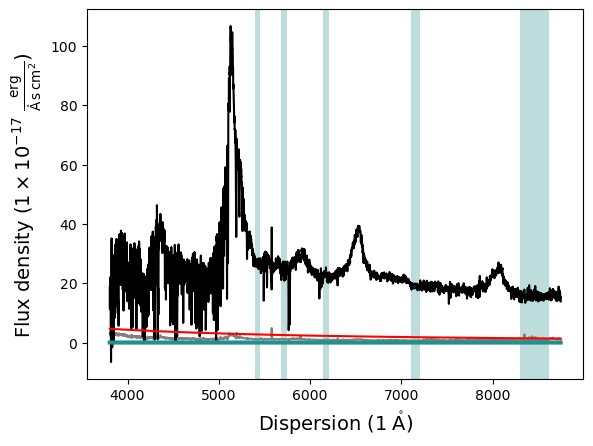

In [82]:
contmodel.plot() #Just to see if the above mask corresponds to the line free channels

In [83]:
#Now fit the continuum
contmodel.fit()

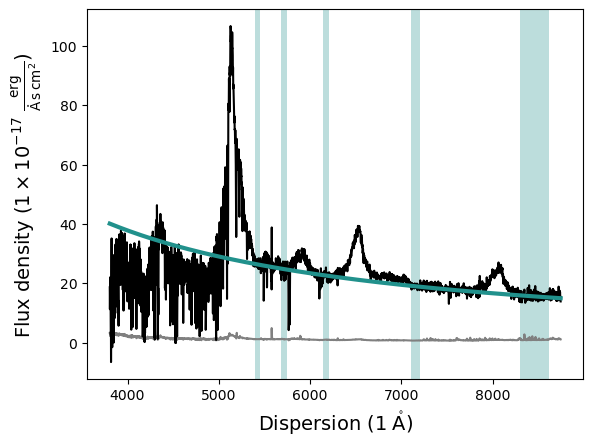

In [84]:
#Now let's plot the fit
contmodel.plot()

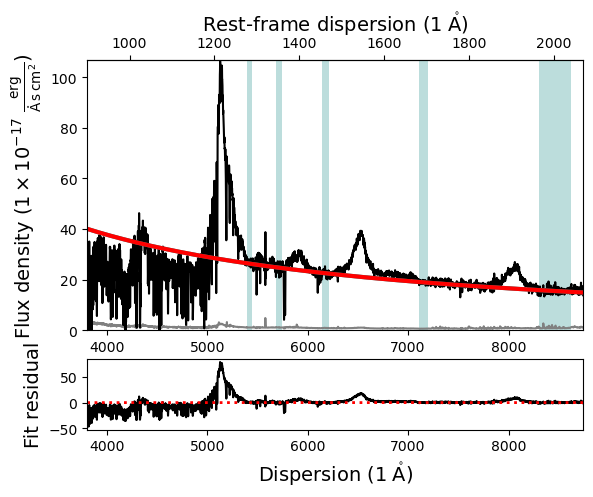

In [85]:
fit.plot()

In [86]:
contmodel.fit_result

In [87]:
#Let us fit the SiIV, CIV and CIII] lines. First the SiIV line

In [88]:
# Add the SiIV emission line model
fit.add_specmodel()

# Access the SpecModel object by choosing the second SpecModel object
siiv_model = fit.specmodels[1]
siiv_model.name = 'SiIV_line'

#Add mask to fit the Si IV line
#siiv_model.add_wavelength_range_to_fit_mask(5750, 6150)
siiv_model.add_wavelength_range_to_fit_mask(5790, 5870)
siiv_model.add_wavelength_range_to_fit_mask(5910, 6015)

[INFO] Manual mask range 5790 5870
[INFO] Manual mask range 5910 6015


In [89]:
model_name = 'SiIV (2G components)'
model_prefix = None
siiv_model.add_model(model_name, model_prefix)

In [90]:
siiv_model.model_list

[Model(line_model_gaussian, prefix='SiIV_A_'),
 Model(line_model_gaussian, prefix='SiIV_B_')]

In [91]:
siiv_model.params_list[0]

name,value,initial value,min,max,vary
SiIV_A_z,3.22700000,3.227,3.06565000,3.38835000,False
SiIV_A_flux,532.233510,532.2335097156131,0.00000000,532233.510,True
SiIV_A_cen,1399.80000,1399.8,-inf,inf,False
SiIV_A_fwhm_km_s,2500.00000,2500,300.000000,20000.0000,True


In [92]:
siiv_model.params_list[1]

name,value,initial value,min,max,vary
SiIV_B_z,3.22700000,3.227,3.06565000,3.38835000,False
SiIV_B_flux,532.233510,532.2335097156131,0.00000000,532233.510,True
SiIV_B_cen,1399.80000,1399.8,-inf,inf,False
SiIV_B_fwhm_km_s,2500.00000,2500,300.000000,20000.0000,True


In [93]:
siiv_model.params_list[0]['SiIV_A_z'].vary = True
siiv_model.params_list[1]['SiIV_B_z'].vary = True

In [94]:
#siiv_model.params_list[0]['SiIV_A_fwhm_km_s'].max = 30000.0000

In [95]:
# Fit the SiIV SpecModel
siiv_model.fit()

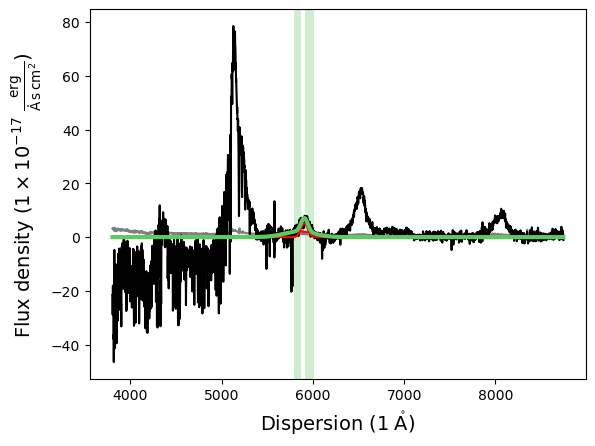

In [96]:
siiv_model.plot()

In [97]:
siiv_model.fit_result

In [98]:
#Now the C IV line

fit.add_specmodel()
civ_model = fit.specmodels[2]
civ_model.name = 'CIV_line'
civ_model.add_wavelength_range_to_fit_mask(6340, 6700)

[INFO] Manual mask range 6340 6700


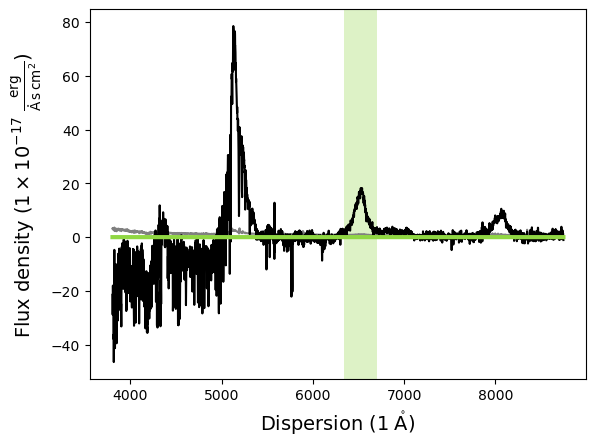

In [99]:
civ_model.plot()

In [100]:
model_name = 'CIV (2G components)'
model_prefix = None
civ_model.add_model(model_name, model_prefix, amplitude=10)

In [101]:
# Make the redshift a variable parameter
civ_model.params_list[0]['CIV_A_z'].vary = True
civ_model.params_list[1]['CIV_B_z'].vary = True

In [102]:
civ_model.fit()

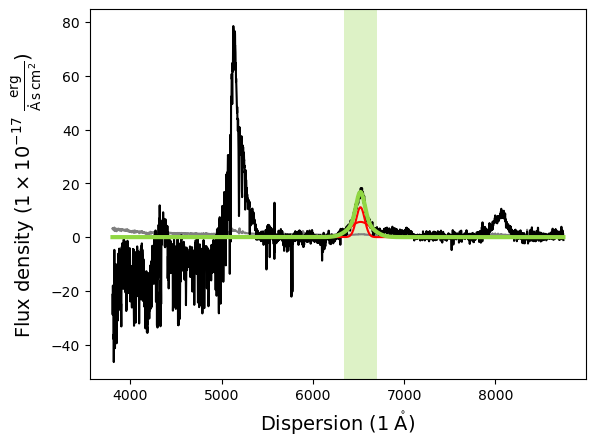

In [103]:
civ_model.plot()

In [104]:
civ_model.fit_result

In [105]:
# Add the CIII] complex emission line model

# Add the CIII] complex emission line model
fit.add_specmodel()
ciii_model = fit.specmodels[3]
ciii_model.name = 'CIII]_complex'

ciii_model.add_wavelength_range_to_fit_mask(7800, 8400)

model_name = 'CIII] complex (3G components)'
model_prefix = None
ciii_model.add_model(model_name, model_prefix, amplitude=2)

ciii_model.params_list[0]['CIII_z'].vary = True

# Initial fit
ciii_model.fit()

[INFO] Manual mask range 7800 8400


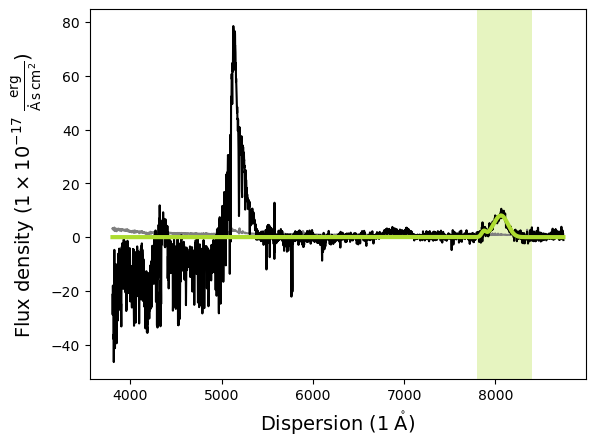

In [106]:
ciii_model.plot() #Model has already converged

In [107]:
# Second fit to make sure the model converged
ciii_model.fit()

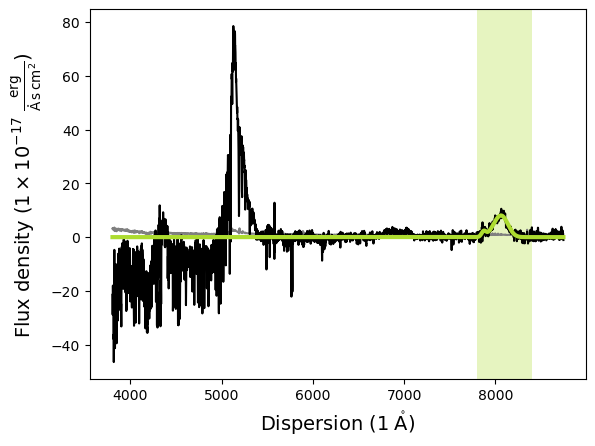

In [108]:
ciii_model.plot()

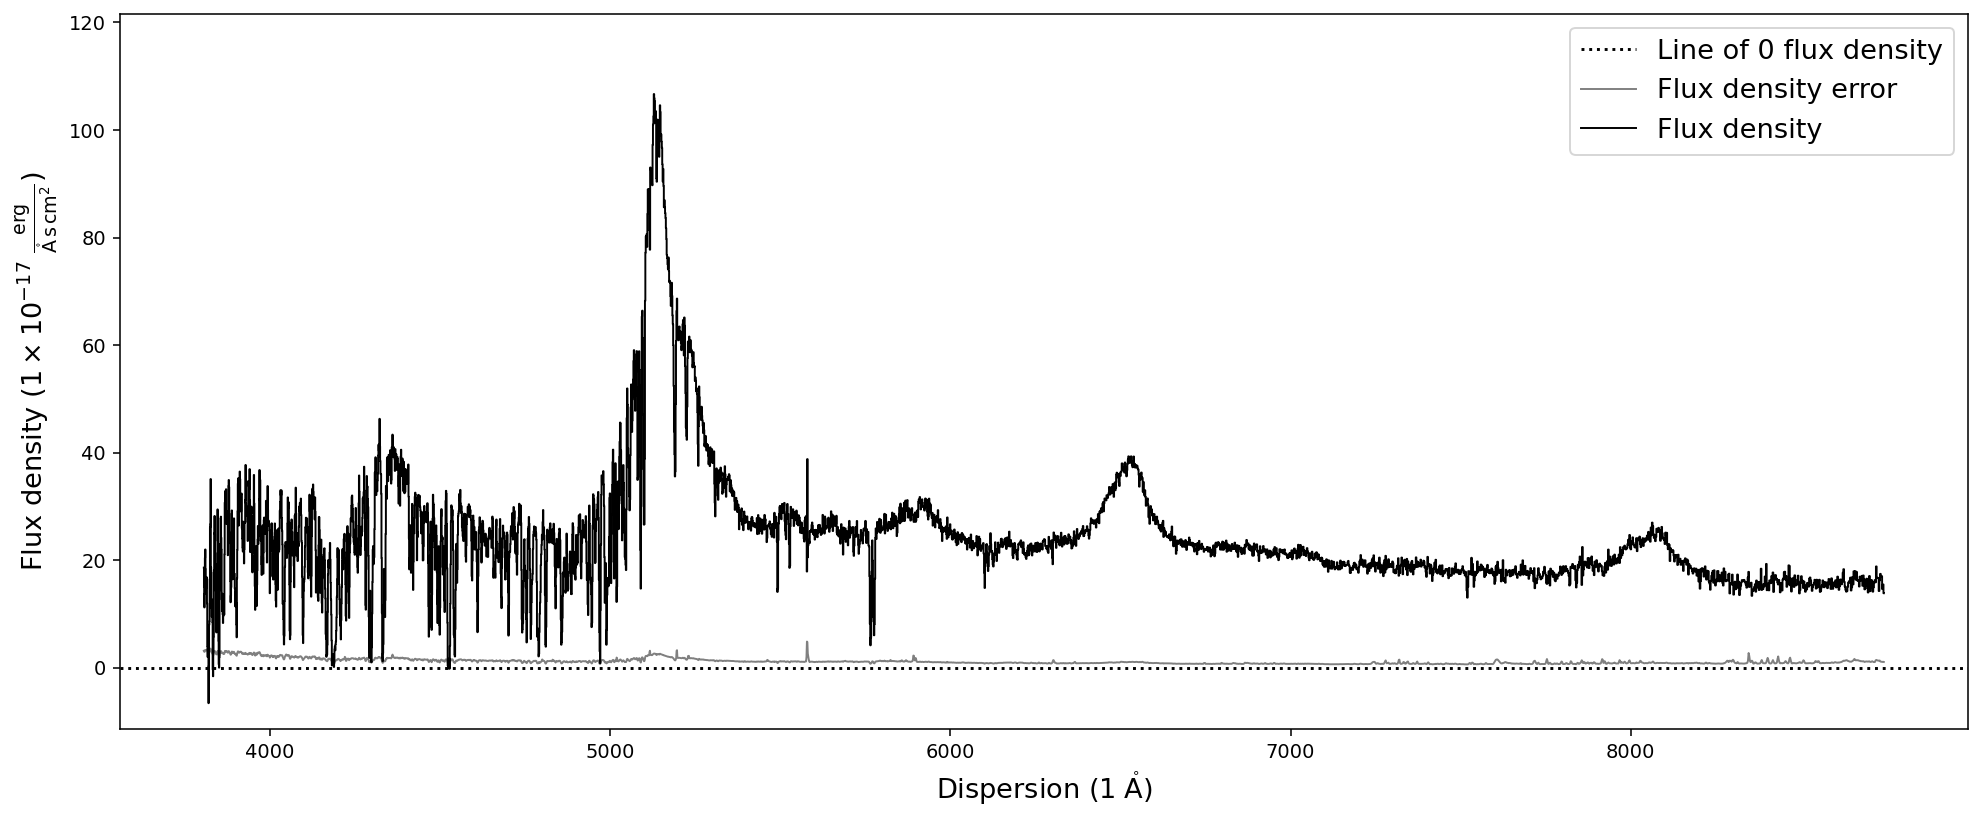

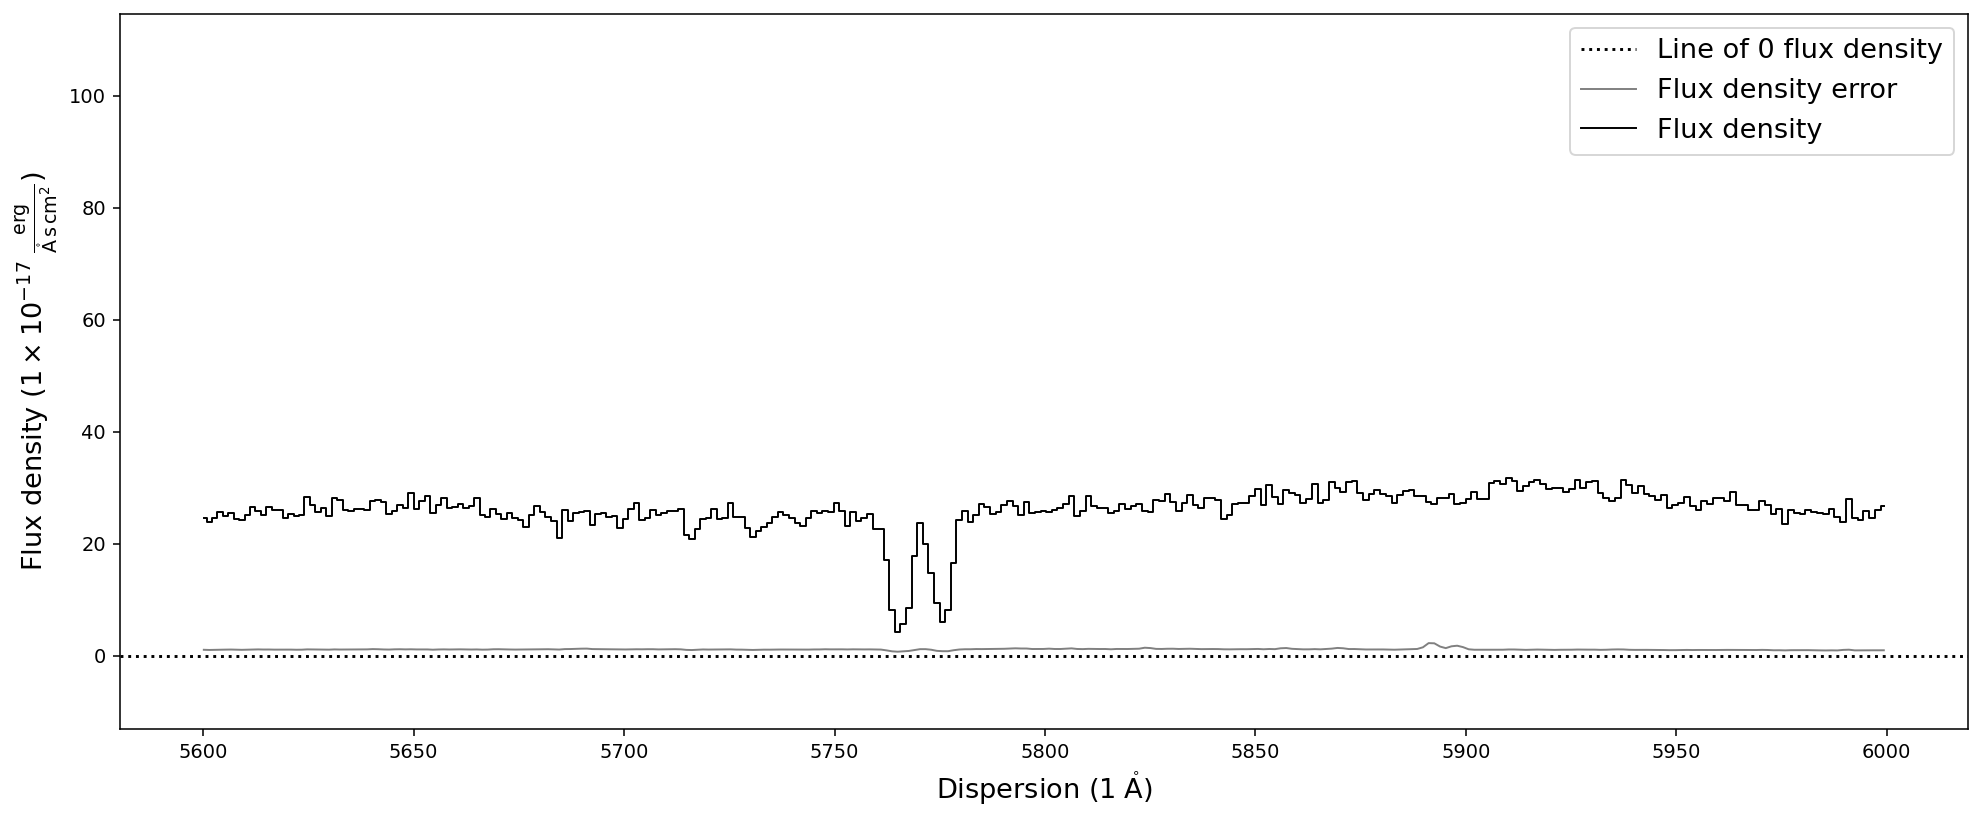

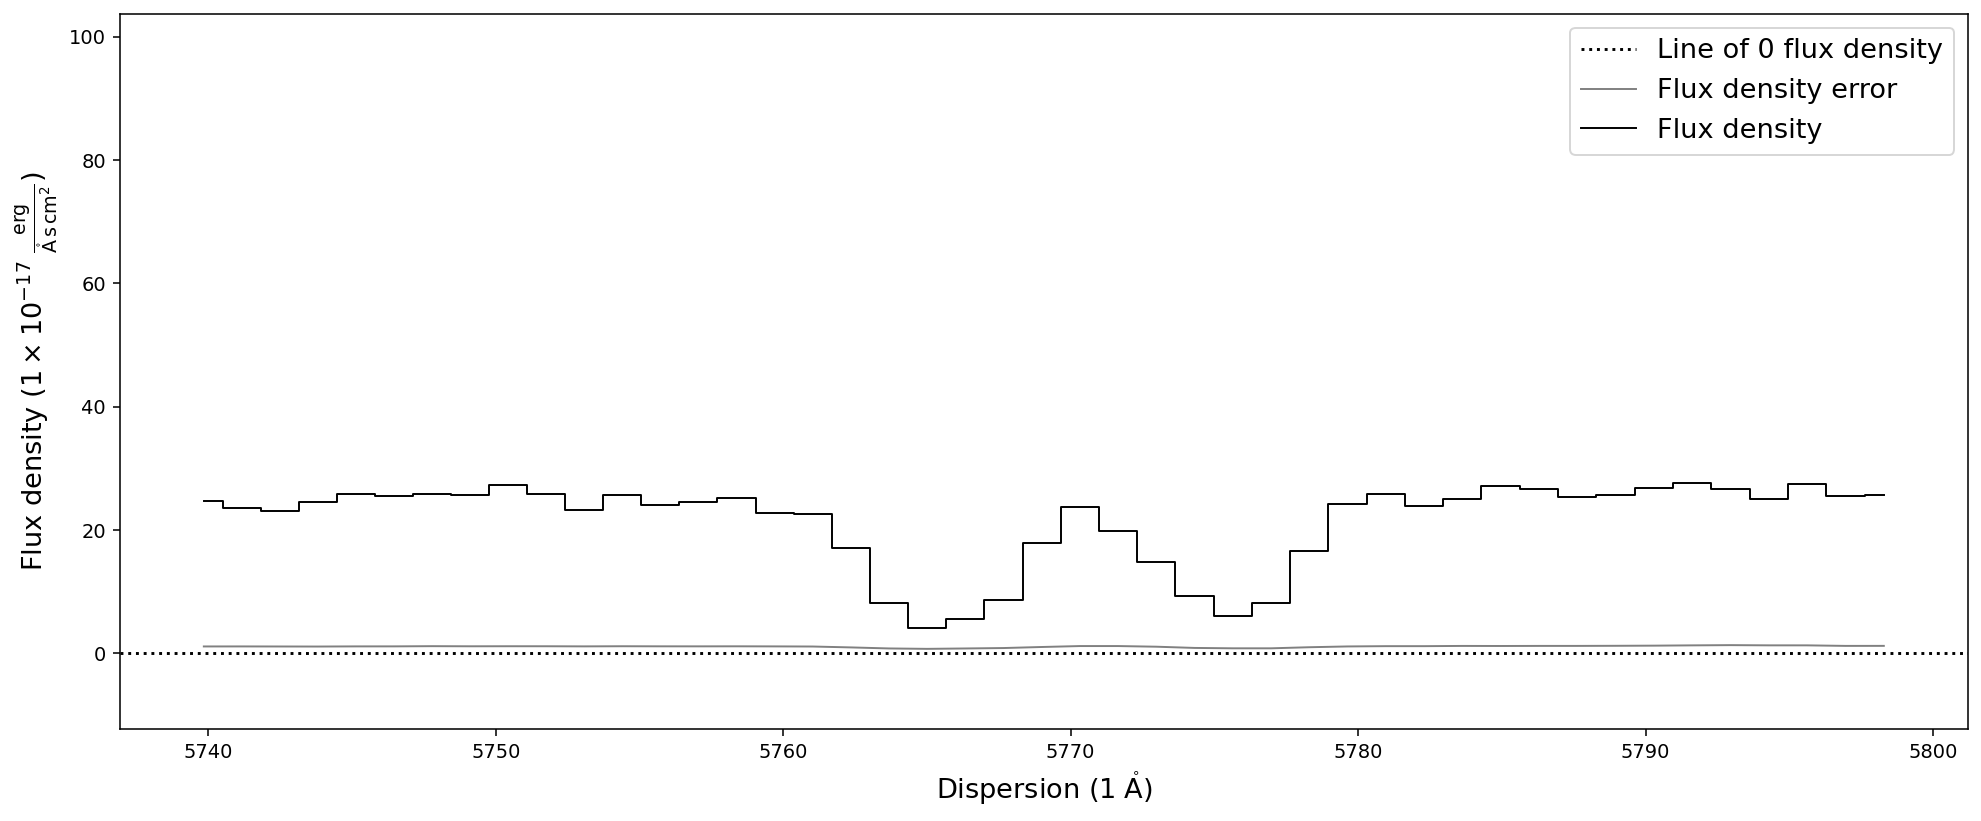

In [109]:
#Fitting absorption lines
spec.plot(ymax=40)
spec.trim_dispersion([5600,6000]).plot(ymax=40)
spec.trim_dispersion([5740,5800]).plot(ymax=40) #TWo absorption features

In [110]:
fit.add_specmodel()
abs_model = fit.specmodels[4]
abs_model.name = 'Abs_lines'

In [111]:
abs_model.add_wavelength_range_to_fit_mask(5755, 5785)

[INFO] Manual mask range 5755 5785


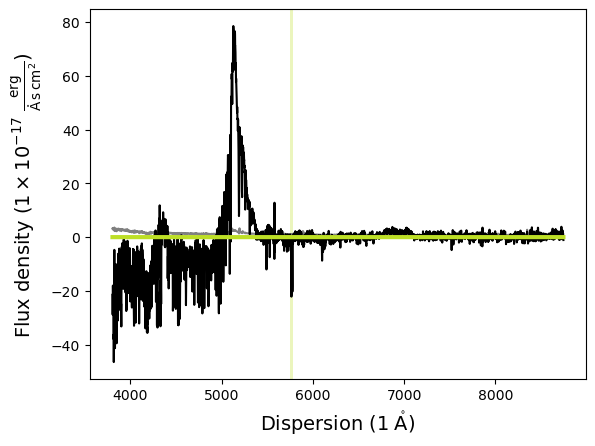

In [112]:
abs_model.plot()

In [113]:
"""
Wait, how did the spectrum y axis change when I introduce a model? Is th continuum subtracted automatically?

That's the only plausable explaination
"""

"\nWait, how did the spectrum y axis change when I introduce a model? Is th continuum subtracted automatically?\n\nThat's the only plausable explaination\n"

In [114]:
model_name = 'Line model Gaussian'
model_prefix = 'Abs_A'
abs_model.add_model(model_name, model_prefix, amplitude=-20, cenwave=5766, fwhm=200, redshift=0)

model_name = 'Line model Gaussian'
model_prefix = 'Abs_B'
abs_model.add_model(model_name, model_prefix, amplitude=-20, cenwave=5776, fwhm=200, redshift=0)

In [115]:
abs_model.fit()

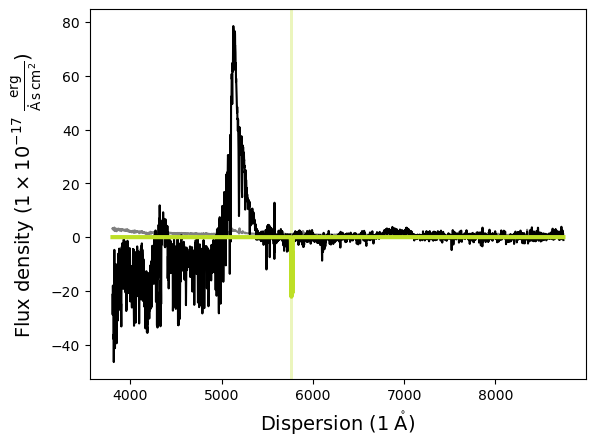

In [116]:
abs_model.plot()

In [117]:
abs_model.fit_result

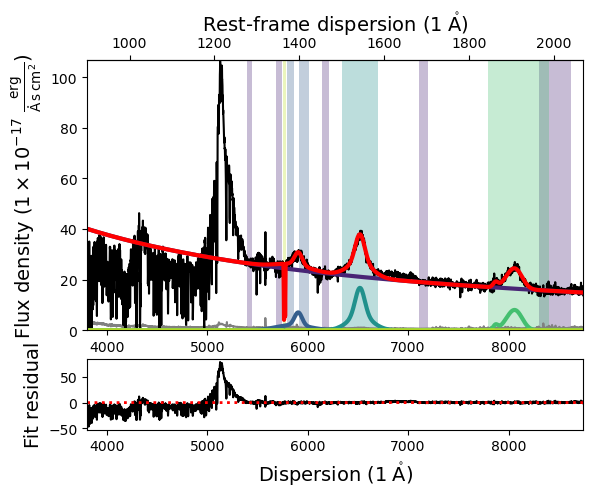

In [118]:
fit.plot() #All fits

In [119]:
#Save all fit reports
fit.fit(save_results=True)

In [120]:
! ls

example_fit			   specmodel_2_FitAll_fit_report.txt
J030341.04-002321.8_0.fits	   specmodel_3_FitAll_fit_report.txt
specmodel_0_FitAll_fit_report.txt  specmodel_4_FitAll_fit_report.txt
specmodel_1_FitAll_fit_report.txt  Untitled.ipynb


In [121]:
! rm *.txt

In [122]:
! ls

example_fit  J030341.04-002321.8_0.fits  Untitled.ipynb


In [123]:
"""

Unable to save the notebook using fir.save().

Throws an error "TypeError: Object of type int64 is not JSON serializable"

"""

'\n\nUnable to save the notebook using fir.save().\n\nThrows an error "TypeError: Object of type int64 is not JSON serializable"\n\n'

In [124]:
#! rm -rf example_fit_notebook

In [125]:
#Save the SpecFit object
#fit.save('example_fit_notebook')

In [126]:
#new_fit = scfit.SpecFit()
#new_fit.load('example_fit_notebook')